## Predicting Sale Price of Houses

Predicting house prices is useful to identify fruitful investments, or to determine whether the price advertised for a house is over or under-estimated.

The aim of the project is to build a machine learning model to predict the sale price of homes based on different explanatory variables describing aspects of residential houses. 


In this post, I will compare various regression models and evaluate their performance using the mean squared error (mse) and the root squared of the mean squared error (rmse).

House Price dataset comes from Kaggle and can be downloaded from 
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data


In [1]:
import numpy
from numpy import arange
from matplotlib import pyplot
import seaborn as sns
import pandas as pd
from pandas import set_option

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [3]:
# load dataset
data = pd.read_csv('train.csv', index_col='Id')
data.shape

(1460, 80)

The house price dataset contains 1460 rows, i.e., houses, and 81 columns, i.e., variables. 

**This post is divided into the following modeling steps:**

1. Explatory Data Analysis and Cleaning
2. Feature Enigneering
    - 2.1 Numerical features
    - 2.2 Categorical features
3. Feature Selection
4. Modeling Development
5. Evaluation

###  Explatory Data Analysis and Cleaning

Let's try to understand the dataset and perform some univariate analysis. Before we start our analysis, let's split our data to train and test datasets

The age of a house may be more important predictor of the price than they year the house is sold. Let's get the age of the house.

In [4]:
data['age'] = data['YrSold']-data['YearBuilt']

#Let's remove 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold'
data.drop(labels=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold'], axis=1, inplace=True)

In [5]:
# make list of numerical variables
num_vars = [var for var in data.columns if data[var].dtypes != 'O']

# make list of categorical variables
cat_vars = [var for var in data.columns if data[var].dtypes == 'O']

print('Number of numerical variables: ', len(num_vars))
print('Number of categorical variables: ', len(cat_vars))

Number of numerical variables:  34
Number of categorical variables:  43


The data contains 35 numerical and 43 categorical features. Each category requires different feature engineering - which will be discussed in the latter sections.

### Numerical Features

Let's identity variables with missing values and impute the values with 'mean'

In [6]:
num_vars_na = [var for var in num_vars if data[var].isnull().sum()>0]

In [7]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit(data[num_vars_na])

data[num_vars_na] = imputer.transform(data[num_vars_na])

In [8]:
#check if there is a numerical variable missing values
[var for var in num_vars if data[var].isnull().sum()>0]

[]

Numerical feauture could have discrete or continuous values

Let's go ahead and find which variables are discrete, i.e., show a finite number of values

In [9]:
#list of discrete variables
discrete_vars = [var for var in num_vars if len(
    data[var].unique()) < 20]


print('Number of discrete variables: ', len(discrete_vars))

Number of discrete variables:  14


In [10]:
# let's visualise the discrete variables

data[discrete_vars].head()

,MSSubClass,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,PoolArea,MoSold
Id,,,,,,,,,,,,,,
1,60,7,5,1,0,2,1,3,1,8,0,2,0,2
2,20,6,8,0,1,2,0,3,1,6,1,2,0,5
3,60,7,5,1,0,2,1,3,1,6,1,2,0,9
4,70,7,5,1,0,1,0,3,1,7,1,3,0,2
5,60,8,5,1,0,2,1,4,1,9,1,3,0,12


It is important to have monotonic relationship between the discrete variables and the sales price. Let's analyze that.

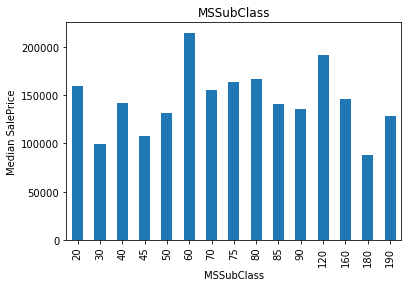

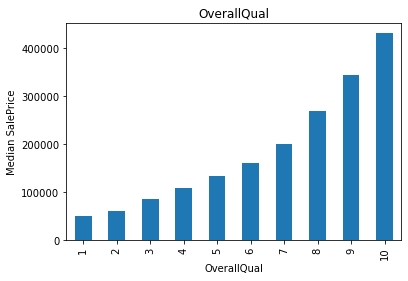

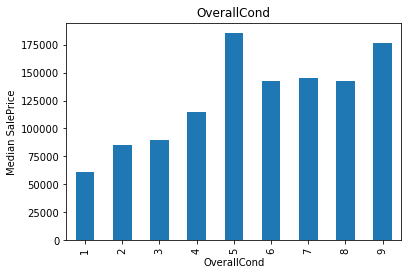

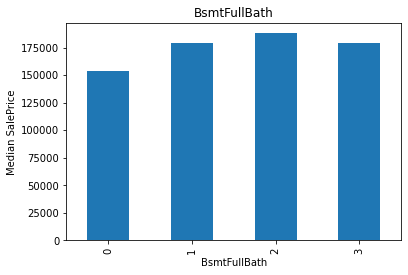

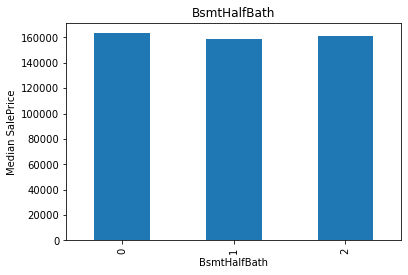

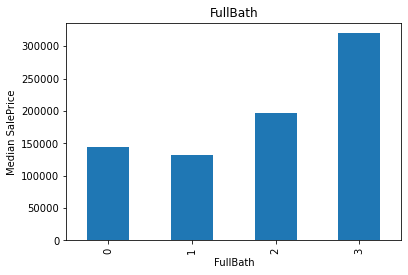

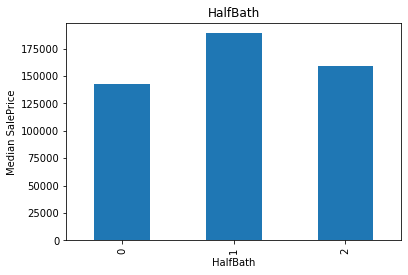

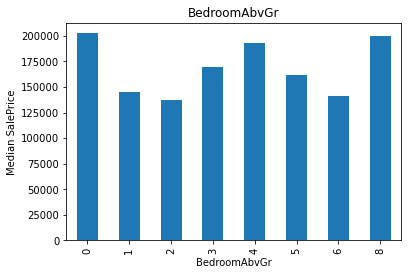

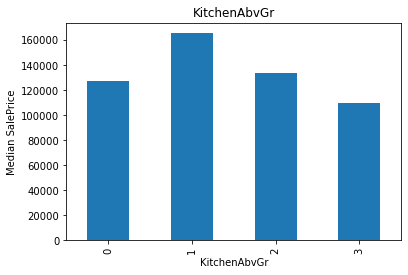

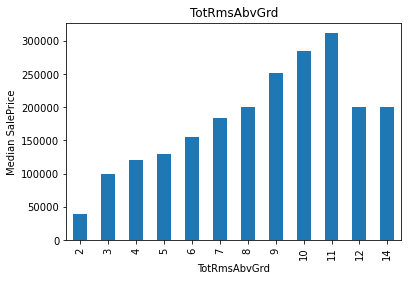

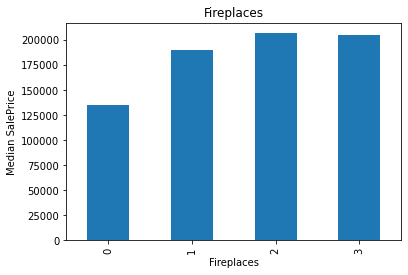

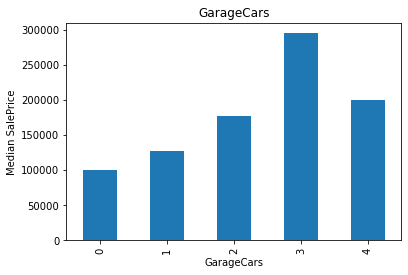

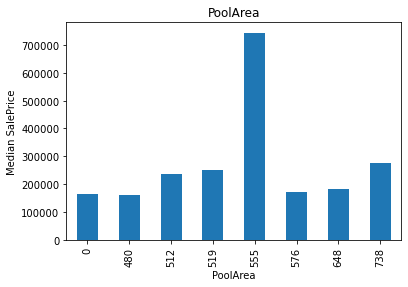

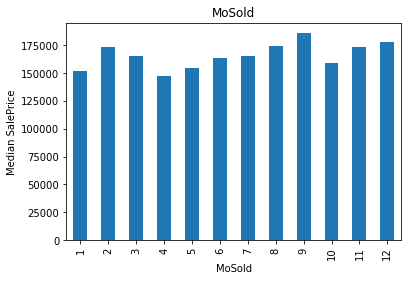

In [11]:
def analyse_discrete_features(df, var):
    df = df.copy()
    df.groupby(var)['SalePrice'].median().plot.bar()
    plt.title(var)
    plt.ylabel('Median SalePrice')
    plt.show()
    
for var in discrete_vars:
    analyse_discrete_features(data, var)

There tend to be a relationship between the variables values and the SalePrice, but this relationship is not always monotonic. 

For example, for OverallQual, there is a monotonic relationship: the higher the quality, the higher the SalePrice.  On the other hand, MoSold doesn't show any monotonic relationship.

Let's remove the features that doesn't show any monotonic relationship.


In [12]:
data.drop(labels=['MSSubClass', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 
                        'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces','PoolArea', 'MoSold'], axis=1, inplace=True)    

#### Continuous variables

Let's go ahead and find the distribution of the continuous variables. We will consider continuous variables to all those that are not temporal or discrete variables in our dataset.

In [13]:
# make list of continuous variables
cont_vars = [
    var for var in num_vars if var not in discrete_vars]

print('Number of continuous variables: ', len(cont_vars))

Number of continuous variables:  20


In [14]:
# let's visualise the continuous variables

data[cont_vars].head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice,age
Id,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,706,0,150,856,856,854,0,1710,548,0,61,0,0,0,0,208500,5
2,80.0,9600,0.0,978,0,284,1262,1262,0,0,1262,460,298,0,0,0,0,0,181500,31
3,68.0,11250,162.0,486,0,434,920,920,866,0,1786,608,0,42,0,0,0,0,223500,7
4,60.0,9550,0.0,216,0,540,756,961,756,0,1717,642,0,35,272,0,0,0,140000,91
5,84.0,14260,350.0,655,0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,0,250000,8


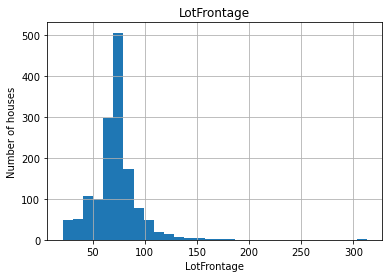

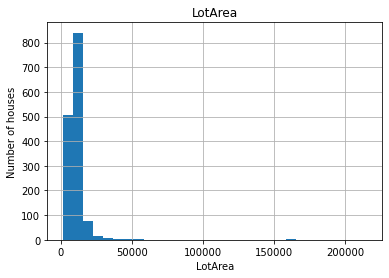

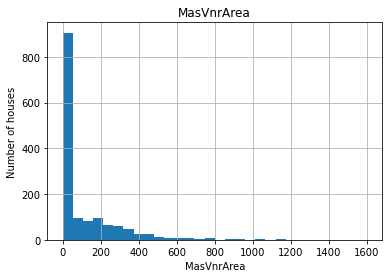

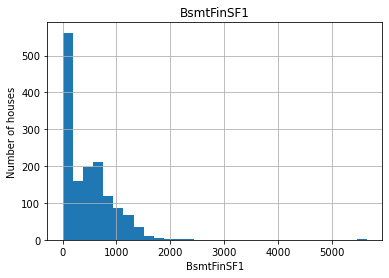

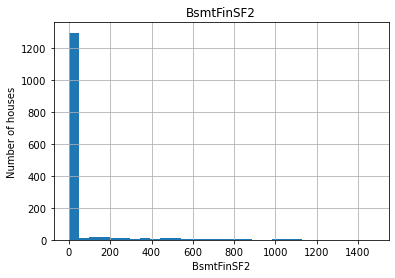

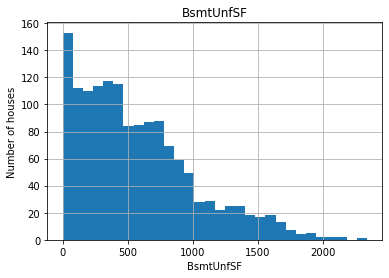

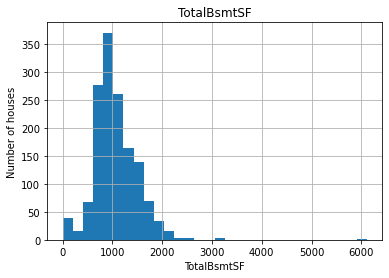

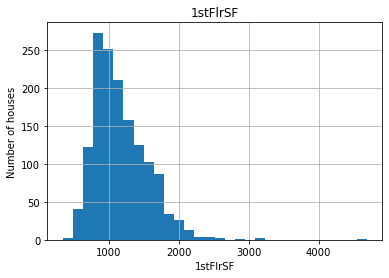

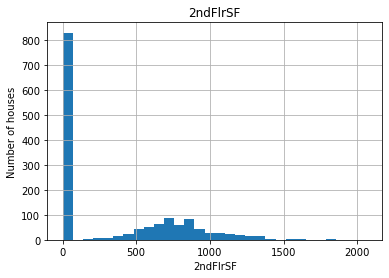

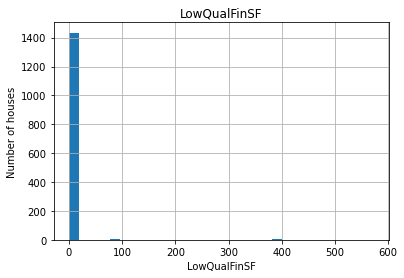

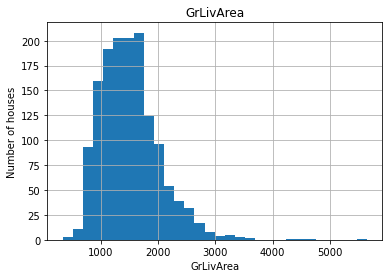

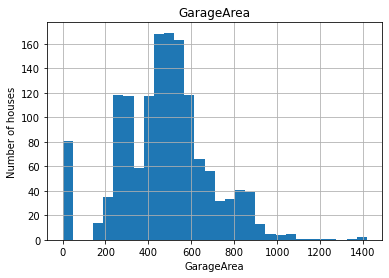

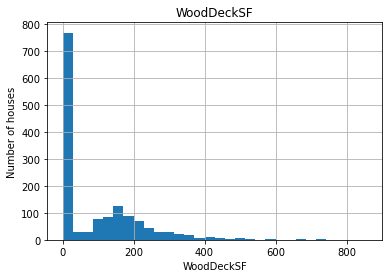

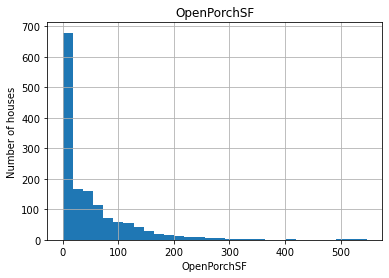

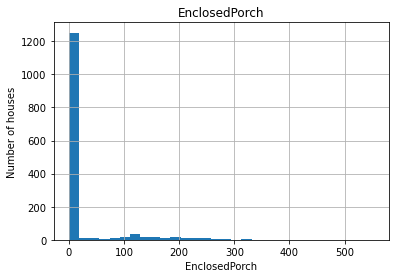

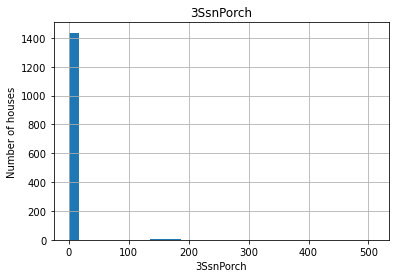

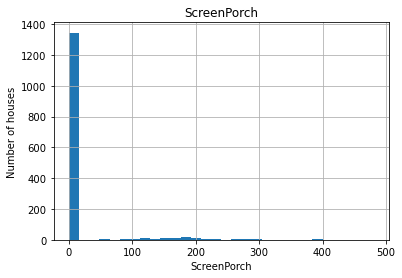

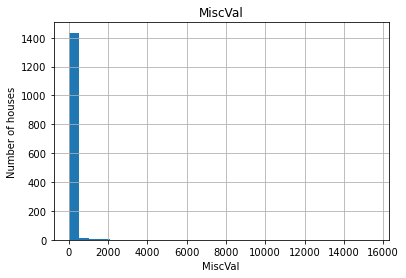

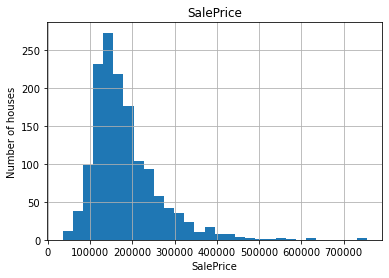

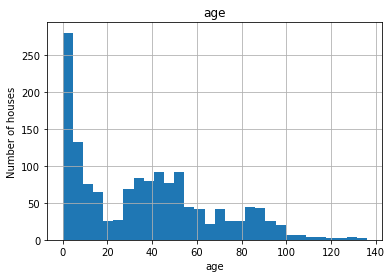

In [15]:
# Let's go ahead and analyse the distributions of these variables

def analyse_continuous_features(df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of houses')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in cont_vars:
    analyse_continuous_features(data, var)

The variables are not normally distributed, including the target variable 'SalePrice'. 

To maximise performance of linear models, we need to account for non-Gaussian distributions.

Let's evaluate if a logarithmic transformation of the variables returns values that follow a normal distribution:

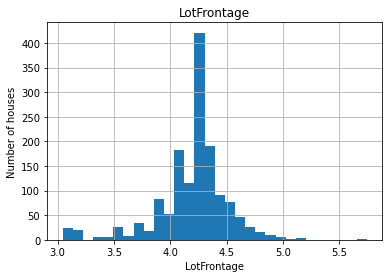

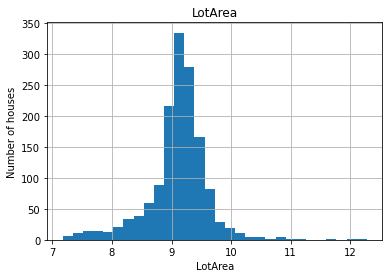

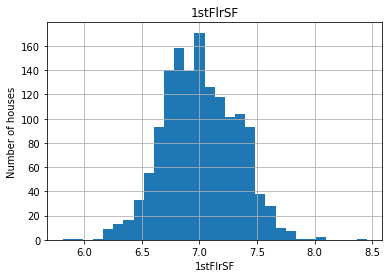

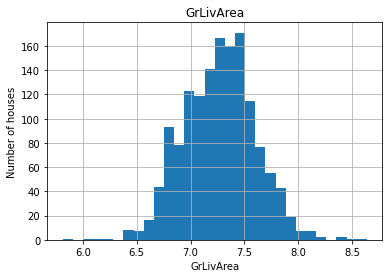

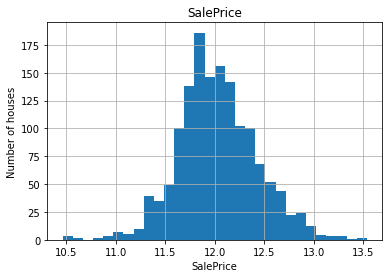

In [16]:
# Let's go ahead and analyse the distributions of these variables
# after applying a logarithmic transformation


def analyse_transformed_continuous(df, var):
    df = df.copy()

    # log does not take 0 or negative values, so let's be
    # careful and skip those variables
    if any(data[var] <= 0):
        pass
    else:
        # log transform the variable
        df[var] = np.log(df[var])
        df[var].hist(bins=30)
        plt.ylabel('Number of houses')
        plt.xlabel(var)
        plt.title(var)
        plt.show()


for var in cont_vars:
    analyse_transformed_continuous(data, var)

We get a better spread of the values for most variables when we use the logarithmic transformation. 

### Categorical Variables

For categorical variables, we will replace missing values with the string the most frequent label

In [17]:
# make a list of the categorical variables that contain missing values

cat_vars_na = [var for var in cat_vars if data[var].isnull().sum() > 0]

# print percentage of missing values per variable
data[cat_vars_na].isnull().mean()

Alley           0.937671
MasVnrType      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

Several features have many missing values. Let's remove freatures with 50% missing values and replace missing values for the remaining features with the most frequent value -- the mode.

In [18]:
pct_missing = data[cat_vars_na].isnull().mean()
cat_few_missing = pct_missing[pct_missing<0.5].index
cat_few_missing

Index(['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond'],
      dtype='object')

In [19]:
for var in cat_few_missing:
    mode = data[var].mode(dropna=True)
    
    data[var] = data.fillna(mode)  

remove features with >50% missing value

In [20]:
many_missing = pct_missing[pct_missing>=0.5].index
data.drop(labels = many_missing, axis=1, inplace=True)

Replace rare values with 'Rare'

In [21]:
cat_vars = [var for var in data.columns if data[var].dtypes == 'O']

In [22]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(data, var, 0.01)
    
    # replace rare categories by the string "Rare"
    data[var] = np.where(data[var].isin(
        frequent_ls), data[var], 'Rare')

### Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers. We will do it so that we capture the monotonic relationship between the label and the target.


In [23]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean house sale price

def replace_categories(df, var, target):
    
    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = df.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    df[var] = df[var].map(ordinal_label)

In [24]:
for var in cat_vars:
    replace_categories(data, var, 'SalePrice')

In [25]:
# let me show you what I mean by monotonic relationship
# between labels and target

def analyse_vars(df, var):
    
    # function plots median house sale price per encoded
    # category
    
    df = df.copy()
    df.groupby(var)['SalePrice'].mean().plot.bar()
    plt.title(var)
    plt.ylabel('SalePrice')
    plt.show()


Let's visualize the montonic relationship between the target and the transformed categorical variables.

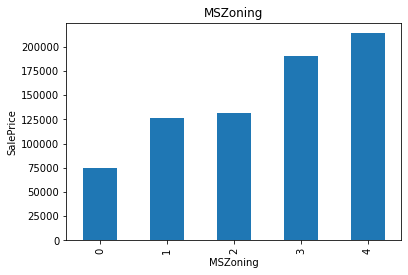

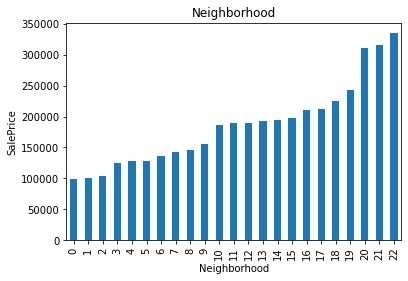

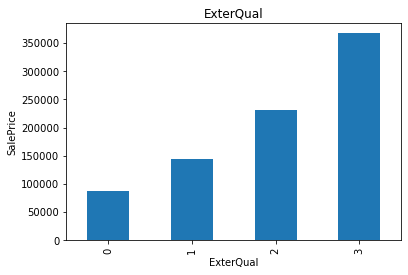

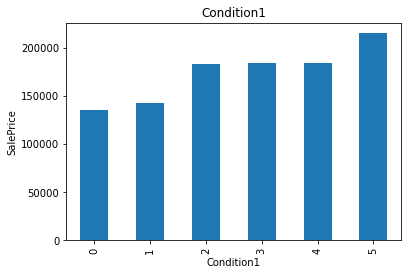

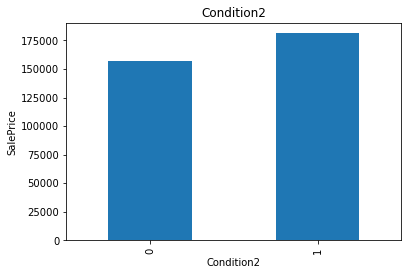

In [26]:
    
train = data.copy()
train['SalePrice2'] = np.exp(data['SalePrice'])
for var in ['MSZoning', 'Neighborhood', 'ExterQual', 'Condition1', 'Condition2']:
    analyse_vars(train, var)

The monotonic relationship is particularly clear for the variables MSZoning, Neighborhood, and ExterQual. Note how, the higher the integer that now represents the category, the higher the mean house sale price.

### Feature Selection

Let's go ahead and select a subset of the most predictive features. There is an element of randomness in the Lasso regression, so remember to set the seed. we use the selectFromModel object from sklearn, which will select automatically the features which coefficients are non-zero.

In [27]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
# remember to set the seed, the random state in this function
sel_ = SelectFromModel(Lasso(alpha=0.005, tol=0.1, random_state=0))

X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

# train Lasso model and select features
sel_.fit(X, y)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0, tol=0.1))

In [28]:
# let's visualise those features that were selected.
# (selected features marked with True)

sel_.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [29]:
features = X.columns

In [30]:
len(features[sel_.get_support()])

57

In [31]:
# let's print the number of total and selected features

# this is how we can make a list of the selected features
selected_feats = pd.DataFrame(X).columns[(sel_.get_support())]

# let's print some stats
print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_feats)))

total features: 63
selected features: 57


### Identify the selected variables

In [32]:
# reduce the train and test set to the selected features
selected_features = features[sel_.get_support()]

X = X[selected_features]



## Feature Scaling

For use in linear models, features need to be either scaled or normalised. In the next section, I will scale features to the minimum and maximum values:

In [33]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X) 

# transform the train and test set
X = scaler.transform(X)


### Model Fitting and Comparison

In [34]:
# import models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score

In [35]:
models = []
#models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(alpha=0.005, random_state=0)))
models.append(('EN', ElasticNet(alpha= 0.05, l1_ratio =  0.8)))
models.append(('Ridge', Ridge()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
#models.append(('SVR', SVR()))

In [36]:
r2_scores = []
mrse_scores = []
r2_scores_all = []
names = []
for name, model in models:
    
    #model = model.fit(X, y)
    
    r2 = cross_val_score(model, X, y, scoring = 'r2', cv=10)
    r2_mean = round(r2.mean(),3)
    mse = cross_val_score(model, X, y, scoring ='neg_mean_squared_error', cv=10)
    mrse = round(np.sqrt(-mse).mean(),1)
    r2_scores.append(r2_mean)
    mrse_scores.append(mrse)
    
    r2_scores_all.append(r2)

    names.append(name)
results = pd.DataFrame(list(zip(names, r2_scores, mrse_scores)),
            columns=['Model', 'R2-Score', 'MRSE']).set_index('Model')
results.sort_values('MRSE')

,R2-Score,MRSE
Model,,
RF,0.874,27715.7
EN,0.815,33415.4
Ridge,0.814,33493.7
LASSO,0.814,33500.7
KNN,0.765,38080.3
CART,0.752,39929.3


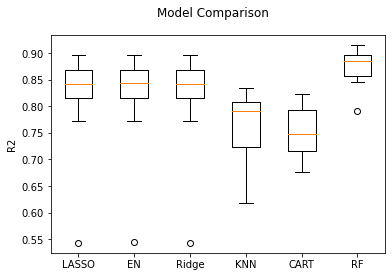

<Figure size 432x288 with 0 Axes>

In [39]:
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(r2_scores_all)
ax.set_xticklabels(names)
plt.ylabel('R2')
plt.show()
plt.savefig('model_comparison.png', transparent=True)

The RandomForestRegressor appears to be the best model in terms of both R2 and mean root squared error.